# Getting the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

%matplotlib inline
# to make this notebook's output stable across runs
np.random.seed(42)

In [2]:
dftrain = pd.read_csv('train.csv')
dftest = pd.read_csv('test.csv')

# Getting to know the Data

In [3]:
dftrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


There are 12 attributes in train data set with 891 instances. As observing here, the 'age' attribute is missing some instances (177 instances to be precise), 'embarked' attribute is also missing 2 instances. 

In [5]:
dftrain.describe ()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Data Visualization and Discovery

## Data Visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA6B247A58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001AA6B921F98>]], dtype=object)

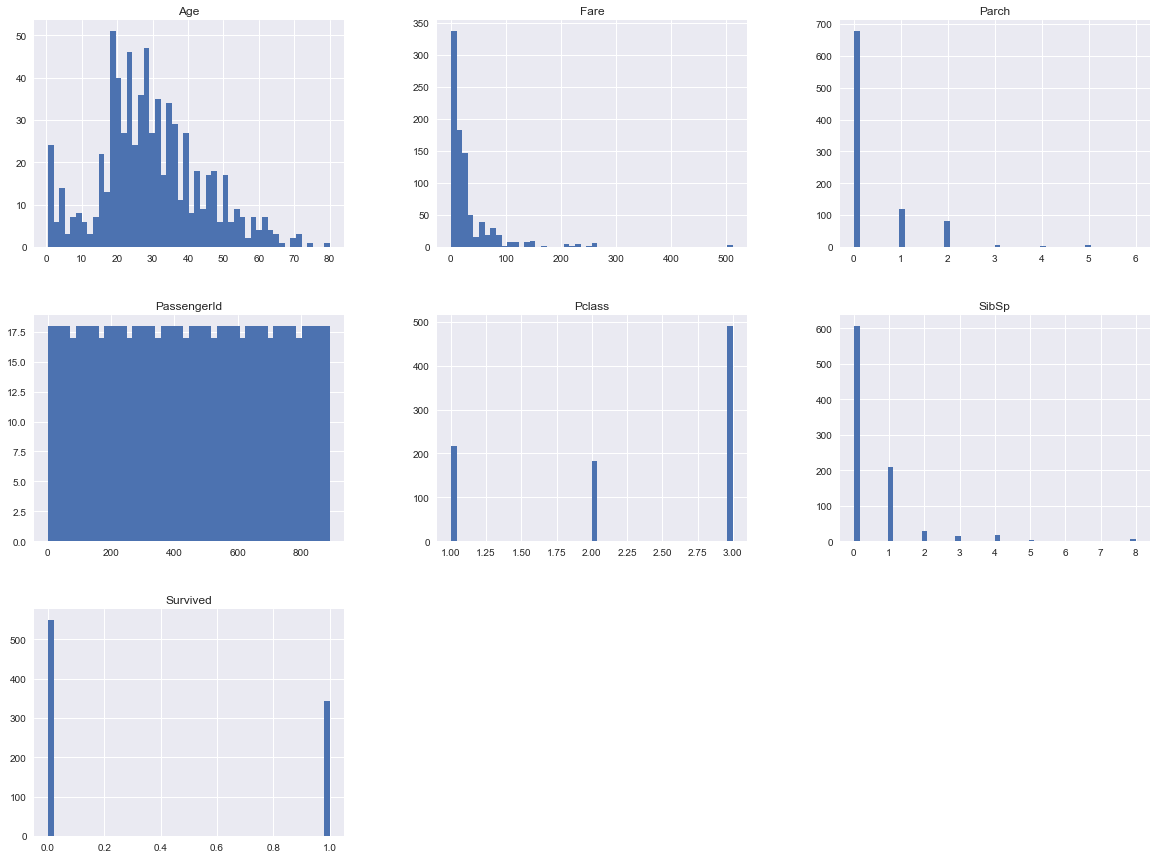

In [6]:
dftrain.hist(bins = 50, figsize = (20,15))

There are few things to notice in the histograms: 
1. In the 'Age' histogram, the data skews to the right, with majority of people at age between 20-30 year old. This information is helpful for later when we deal with the missing values. 
2. In the 'Parch' histogram, it shows that most people didn't travel with their families, about 200 people travelled with their families. 
3. From 'Pclass' histogram, most of people were in class 3, and more in class 1 than class 2.
4. More people died in the tragedy than survived. 


I'm actually curious if the socio-economic status has anything to do with the survival chance

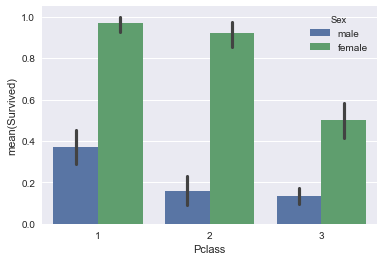

In [7]:
sns.barplot (y = 'Survived', x = 'Pclass', hue = 'Sex', data = dftrain)

From the barplot, class 1 and 2 had the most people surived, and class 3 had the lowest (maybe being rich has its advantage). Most men did not surivied this tragic event, and more women survived 


I'm also curious about how the survival as the age increase

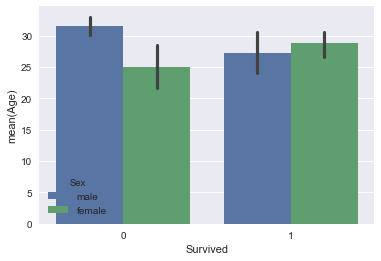

In [8]:
sns.barplot (x = 'Survived', y = 'Age', hue = 'Sex', data = dftrain)

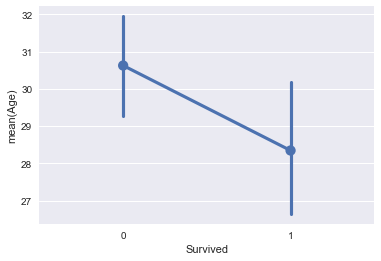

In [9]:
sns.pointplot (x = 'Survived', y = 'Age', data = dftrain)

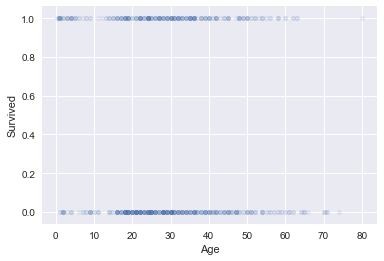

In [10]:
dftrain.plot (kind = 'scatter', x = 'Age', y = 'Survived', alpha = 0.1)

Based on the scatter plot, it seems that there was not many different in the mean age of people who survived or died. however, it does look like many elder people decided to stay back in the ship.

## Data Discovery

### Looking for Correlations

Because the datase is relatively small, it is easy to compute the standard correlation coefficient between every pair of attributes. 

In [11]:
corr_matrix = dftrain.corr()

In [12]:
corr_matrix['Survived'].sort_values(ascending = False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

The correlation is not strong as I would hope for between survival chance and other factors. Nevertheless, 'Survived' attribute has a relatively strong positive correlation with 'fare ticket' attribute, which means as the ticket price increases, the chance of suriviving will also increase. Likewise, 'Survived' attribute also has a relatively strong negative correlation with 'Pclass' attribute, which means as the number of Pclass increases (or the SES is lower), the chance of surviving will decrease. 

# Preprocessing

## Data Cleaning

1. I prefer to divide the attributes such as 'Age', 'Ticket' into a few groups. Why? Because by doing so, it will be easier to avoid overfitting problem, where the outliers create a lot of noise. 
2. I will also remove attributes 'name', 'ticket','Cabin', 'embarked', as it did not provide many insightful information for what we are looking for. 'Cabin' attribute actually would be more useful if there were more data to it. However, because there were only 204 instances in the data (missing ~ 77% data), it would be very difficult to generalize them without creating some bias. 
3. I will use function for these, because it will make the data more flexible to fix if errors occur. In addition, it is always good to practice using function as much as possible because it is very usefull.
4. Because the 'Age' and 'Fare' histograms skew to the right, the best number summary of the center of the distribution will be median; thus, median will be used to fill the missing value in this case.  
5. I made histograms for those I want to divide into groups to avoid any bias from my side. 

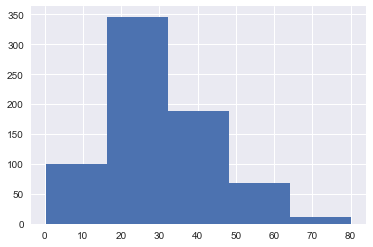

In [13]:
dftrain.Age.hist(bins = 5)

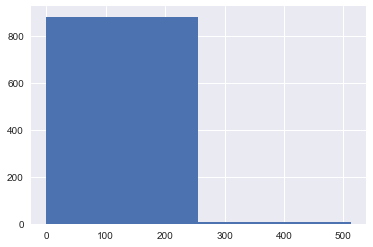

In [14]:
dftrain.Fare.hist(bins = 2)

In [15]:
#Here you can see the advantage of using function. Instead of having to name the instances new name, 
#I can just use the one from the previous function
def preprocessing_age(data):
    median = data.Age.median()
    data.Age = data.Age.fillna(median)
    bins = [0,15,30,45,65,80]
    group_names = ['Kid', 'Young_adult', 'Adult', 'Senior', 'Elder']
    categories = pd.cut(data.Age, bins, labels = group_names)
    data.Age = categories 
    return data 

def preprocessing_fares(data):
    median = data.Fare.median()
    data.Fare = data.Fare.fillna(median)
    bins = [0,50,100,150,200,1000]
    group_names = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
    categories = pd.cut (data.Fare, bins, labels = group_names) 
    data.Fare = categories 
    return data

def preprocessing_drop (data):
    return data.drop(['Ticket', 'Name', 'Embarked', 'Cabin'], axis=1)

def preprocessing (data):
    data = preprocessing_age(data)
    data = preprocessing_fares(data)
    data = preprocessing_drop(data)
    return data

### Now you can do the data cleaning

In [16]:
dftrain = preprocessing(dftrain)
dftest = preprocessing(dftest)

In [17]:
dftrain.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,male,Young_adult,1,0,Q1
1,2,1,1,female,Adult,1,0,Q2
2,3,1,3,female,Young_adult,0,0,Q1
3,4,1,1,female,Adult,1,0,Q2
4,5,0,3,male,Adult,0,0,Q1


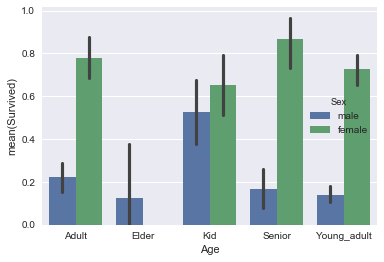

In [18]:
sns.barplot (y = 'Survived', x = 'Age', hue = 'Sex', data = dftrain)

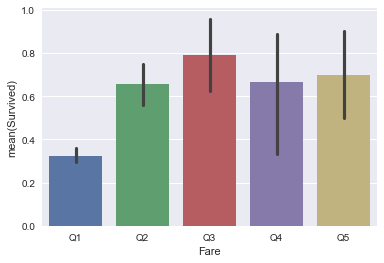

In [19]:
sns.barplot (y = 'Survived', x = 'Fare', data = dftrain)

## Handling Text and Categorial Attributes

In [20]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            891 non-null category
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           876 non-null category
dtypes: category(2), int64(5), object(1)
memory usage: 44.0+ KB


As you can see 'Age' and 'Fare' have been converted to groups, but they are now belong to 'category' type. So we will convert them to unique string values. 'Sex' attribute will also need to convert. sklearn has the preprocessing, however I will use cat.codes.

In [21]:
def convert_category (data):
    data.Age = data.Age.cat.codes
    data.Fare = data.Fare.cat.codes
    return data

In [22]:
dftrain = convert_category(dftrain)
dftest = convert_category(dftest)

def convert_data (data):
    data = pd.concat([data[['Fare', 'Pclass', 'Age', 'Survived']],
                           pd.get_dummies(data['Sex'])],axis=1)
    #data = data.drop('male', 1)
    return data

In [23]:
def convert_data (data):
    data = pd.concat([data[['Fare', 'Pclass', 'Age']],
                           pd.get_dummies(data['Sex'])],axis=1)
    #data = data.drop('male', 1)
    return data

In [24]:
dftrain_convert = convert_data(dftrain)
dftest_convert = convert_data (dftest)
dftrain_convert.head()

,Fare,Pclass,Age,female,male
0,0,3,4,0,1
1,1,1,0,1,0
2,0,3,4,1,0
3,1,1,0,1,0
4,0,3,0,0,1


In [25]:
dftrain_convert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
Fare      891 non-null int8
Pclass    891 non-null int64
Age       891 non-null int8
female    891 non-null uint8
male      891 non-null uint8
dtypes: int64(1), int8(2), uint8(2)
memory usage: 10.5 KB


# Create Test Set 

Because we are looking to predict the survival rate, we will have:
x: all the data except the one we want to predict, which is 'Survived' attribute
y: only the data we want to predict ('Survived'). I will take 20% of the data to make it test set. 

In [26]:
x = dftrain_convert
y = dftrain.Survived

In [27]:
x_train, x_test = train_test_split(x, test_size = 0.2, random_state = 42)
y_train, y_test = train_test_split(y, test_size = 0.2, random_state = 42)

# Select and Train a model

### Linear Regression

In [28]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
y_predictions = lin_reg.predict(dftest_convert)
print('Accuracy score:', lin_reg.score(x_train, y_train))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Accuracy score: 0.360747920517


As you can see, the accuracy is very low with only 36.0% accurate, which means we should try another predicting model. Well, linear regression is not a very powerful model, so we should try other models. 

### Decision Tree Regressor 

In [29]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(x_train, y_train)
y_predictions = tree_reg.predict(dftest_convert)
print('Accuracy score:', tree_reg.score(x_train, y_train))

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

Accuracy score: 0.489819446077


This actually looks better than the Linear Regression, however, the accuracy rate is still so low

### Random Forest Regressor

In [30]:
forest_reg = RandomForestRegressor()
forest_reg.fit(x_train, y_train)
y_pred = forest_reg.predict(dftest_convert)
print('Accuracy score:', forest_reg.score(x_train, y_train))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Accuracy score: 0.480179671656


This is also very low as well. 

### Random Forest Classifier

This is the last model I want to try. I hope it gives better result than the other three previous models

In [31]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(dftest_convert)
print('Accuracy score:', random_forest.score(x_train, y_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Accuracy score: 0.821629213483


So this one has the accuracy score of 82%. I take it! Now that we have one model that looks promissing, we can do the cross-validation to check and tune-in model to see if it improves the accuracy score.

### Cross-Validation 

In [32]:
scores = cross_val_score(random_forest, x_train, y_train, cv=10)
scores

array([ 0.81944444,  0.70833333,  0.70833333,  0.91666667,  0.81690141,
        0.73239437,  0.73239437,  0.74647887,  0.7       ,  0.9       ])

In [33]:
print ('Mean Accuracy: ',scores.mean())

Mean Accuracy:  0.778094679186


# Fine-Tune Model

In [34]:
param_grid = [
    {'n_estimators': [30, 100, 300]},
    {'bootstrap': [False], 
     'n_estimators': [20, 100], 
     'max_features': [2, 3, 4]},
  ]

random_forest = RandomForestClassifier(n_estimators=100)
grid_search = GridSearchCV(random_forest, param_grid, cv=5)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [30, 100, 300]}, {'bootstrap': [False], 'n_estimators': [20, 100], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [35]:
test = grid_search.best_estimator_
test.fit(x_train, y_train)
print('Accuracy score:', test.score(x_train, y_train))

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Accuracy score: 0.821629213483


So the fine-tune doesn't really improve the accuracy score.

# Predict the actual value

In [36]:
titanic_pred = pd.DataFrame({
    'PassengerID' : dftest['PassengerId'],
    'Survived' : y_pred
})
titanic_pred.head()

,PassengerID,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [37]:
#output = titanic_pred
#output.to_csv('titanic-pred.csv', index = False)